### ReAct Agent Architecture Chatbot

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import  StateGraph, START, END
from langgraph.graph.message import add_messages ## work add the msg appeneded to the state

In [3]:
## state
class State(TypedDict):
    # Msg have type list defines how this state key should be updated

    messages : Annotated[list, add_messages] ## appended to the list

graph_builder =StateGraph(State)

graph_builder

In [4]:
## Building the graph

import os
from dotenv import load_dotenv
load_dotenv()


True

In [5]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm =ChatGroq(model="openai/gpt-oss-20b")

In [6]:
## node Chatbot

def chatbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}

In [7]:
# from langchain_community.tools import BraveSearch

In [8]:
from langchain_tavily import TavilySearch

websearch_tool =TavilySearch(max_results=2)


In [9]:
def multiply(a : int, b:int)-> int:
    """ 
    Multiply a and b
    Args:
        a first int
        b seoncd int
    return: 
        int output
    """
    return a*b

def add(a : int, b:int)-> int:
    """ 
    add a and b
    Args:
        a first int
        b seoncd int
    return: 
        int output
    """
    return a+b

In [10]:
tools =[websearch_tool, multiply]
llm_with_tools = llm.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000221465D6120>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000221465D6E40>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

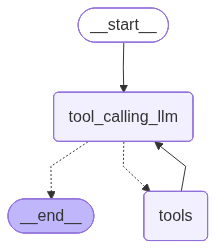

In [11]:
## Stategraph for llm with tool

from langgraph.prebuilt import ToolNode, tools_condition


def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm) ## need to add the name and the definition of the node
builder.add_node("tools", ToolNode(tools))


# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)

## change is here giving feedback here

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [12]:
## Multiplication part
response= graph.invoke({"messages": "give me the latest sora news then What 2*3.3 then add 10"})
response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()

## here you can see tool call happened but only 1st one happened, not the multiply. 

================================ Human Message =================================

give me the latest sora news then What 2*3.3 then add 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_0f58d1ff-8ba9-4f12-820a-1e16457f887a)
 Call ID: fc_0f58d1ff-8ba9-4f12-820a-1e16457f887a
  Args:
    include_favicon: False
    include_images: False
    query: Sora cryptocurrency news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "Sora cryptocurrency news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.forbes.com/digital-assets/assets/sora-xor/", "title": "Sora (XOR) Price Today, News & Live Chart", "content": "$0.000026\n\n$0.00\n\n5 years\n\n$893.18\n\n$0.00\n\n## Sora News & Related Stories\n\nOct 1, 2025\n\n### Crypto Confusion Grows As Unchained Joins Pump.fun Amid SEC Scrutin

In [13]:
response= graph.invoke({"messages": "Who won the asia cup 2025 and thw winning team won how many times give me the sum"})
response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who won the asia cup 2025 and thw winning team won how many times give me the sum
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_35ae06b1-8e4b-49e5-b63c-2317f96f91ed)
 Call ID: fc_35ae06b1-8e4b-49e5-b63c-2317f96f91ed
  Args:
    query: Asia Cup 2025 winner
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "Asia Cup 2025 winner", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.jagranjosh.com/general-knowledge/asia-cup-2025-winner-who-won-the-17th-edition-of-the-asia-cup-t20-check-awards-and-prize-money-1820002959-1", "title": "Asia Cup Winner 2025: Who won the 17th Edition of ... - Jagran Josh", "content": "## Asia Cup 2025 Awards Winners List\n\nHere is the complete award winners list for the Asia Cup 2025 sea

## Memory

In [14]:
from langgraph.checkpoint.memory import MemorySaver

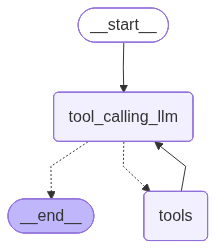

In [15]:
## Stategraph for llm with tool

from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm) ## need to add the name and the definition of the node
builder.add_node("tools", ToolNode(tools))


# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)

## change is here giving feedback here

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

# visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [16]:
## thread id 
config ={"configurable": {"thread_id":"1"}}

response= graph.invoke({"messages":"My name is Souvick"}, config=config)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

My name is Souvick
================================== Ai Message ==================================

Nice to meet you, Souvick! How can I help you today?


In [17]:
response= graph.invoke({"messages":"what is my name ?"}, config=config)
response["messages"][-1].content

'Your name is **Souvick**.'

## Streaming

values and updates

mode = update and value

update >> replaced 
value >> append

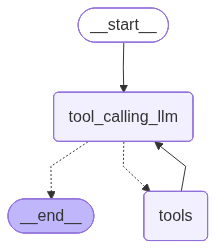

'I’m sorry, but I don’t have any information about your name. If you’d like me to remember it for future reference during this conversation, just let me know!'

In [18]:
def superbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Stategraph for llm with tool

from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm) ## need to add the name and the definition of the node
builder.add_node("tools", ToolNode(tools))


# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)

## change is here giving feedback here

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

# visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



## thread id 
config ={"configurable": {"thread_id":"1"}}

response= graph.invoke({"messages":"what is my name?"}, config=config)
response["messages"][-1].content


In [19]:
config ={"configurable": {"thread_id":"3"}}

# response= graph.invoke({"messages":"My name is Souvick"}, config=config)
for chunk in graph.stream({"messages": "Hi Souvick here"}, config, stream_mode ="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content='Hello Souvick! How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hi Souvick here". Probably just greeting. They might want a response. There\'s no request. Just greet back.'}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 1409, 'total_tokens': 1458, 'completion_time': 0.048435778, 'prompt_time': 0.010643609, 'queue_time': 0.086990275, 'total_time': 0.059079387, 'prompt_tokens_details': {'cached_tokens': 1280}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d587a02fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8984996e-cad3-4603-92d5-e0e87640472b-0', usage_metadata={'input_tokens': 1409, 'output_tokens': 49, 'total_tokens': 1458})]}}


In [20]:
config ={"configurable": {"thread_id":"2"}}

# response= graph.invoke({"messages":"My name is Souvick"}, config=config)
for chunk in graph.stream({"messages": "Hi Souvick here"}, config, stream_mode ="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content='Hello Souvick! How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hi Souvick here". Likely greeting. We respond.'}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1409, 'total_tokens': 1447, 'completion_time': 0.03944025, 'prompt_time': 0.010410892, 'queue_time': 0.086943826, 'total_time': 0.049851142, 'prompt_tokens_details': {'cached_tokens': 1280}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bcf76424-3456-4bcd-b133-8da50e0372b7-0', usage_metadata={'input_tokens': 1409, 'output_tokens': 38, 'total_tokens': 1447})]}}


In [21]:
for chunk in graph.stream({"messages": "what is my name"}, config, stream_mode ="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi Souvick here', additional_kwargs={}, response_metadata={}, id='7fd3dfd8-8480-409c-a5c1-74f176941d9f'), AIMessage(content='Hello Souvick! How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hi Souvick here". Likely greeting. We respond.'}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1409, 'total_tokens': 1447, 'completion_time': 0.03944025, 'prompt_time': 0.010410892, 'queue_time': 0.086943826, 'total_time': 0.049851142, 'prompt_tokens_details': {'cached_tokens': 1280}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bcf76424-3456-4bcd-b133-8da50e0372b7-0', usage_metadata={'input_tokens': 1409, 'output_tokens': 38, 'total_tokens': 1447}), HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='d7e5b91b-a80f-48fe-8ccc-b61554f8d7e8')]}
{'messages': [H